# Description

Chatbot dataset based on a chatbot which it's purpose is to identify people in distress. 

The question the Chatbot asks is: 'Describe a time when you have acted as a resource for someone else'. According to the response of this specific question, a decision should be taken: refer to help or not.

Note: the response indicates if the responder's friend needs help or not.

For example:

Q: 'Describe a time when you have acted as a resource for someone else' A: 'I saved a girl from suicide once. She was going to swallow a bunch of pills and I talked her out of it in a very calm, loving way.'

This response marks as "flagged", therefore the response should be refer to professional help.

Example for a not flagged response:

Q: 'Describe a time when you have acted as a resource for someone else' A: 'i cant think of one really...i think i may have indirectly'


# Goal

The goal is to design and train a model which classify responses. 

# Data set limitation

The data set is small (80 responses), therefore it probably does not cover all the patters for this goal.   

# Implemantation 

I use pytorch for this classification problem


In [1]:
import numpy as np
import torch 
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import spacy as sp
import en_core_web_sm
from spacy import displacy
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset , DataLoader
import seaborn as sn

# Basic data analysis , data cleaning and labeling


In [2]:
df = pd.read_csv('Sheet_1.csv',encoding = "utf-8")

In [3]:
df.head()

,response_id,class,response_text,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,response_1,not_flagged,I try and avoid this sort of conflict,NaN,NaN,NaN,NaN,NaN
1,response_2,flagged,Had a friend open up to me about his mental ad...,NaN,NaN,NaN,NaN,NaN
2,response_3,flagged,I saved a girl from suicide once. She was goin...,NaN,NaN,NaN,NaN,NaN
3,response_4,not_flagged,i cant think of one really...i think i may hav...,NaN,NaN,NaN,NaN,NaN
4,response_5,not_flagged,Only really one friend who doesn't fit into th...,,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 8 columns):
response_id      80 non-null object
class            80 non-null object
response_text    80 non-null object
Unnamed: 3       2 non-null object
Unnamed: 4       0 non-null float64
Unnamed: 5       1 non-null object
Unnamed: 6       0 non-null float64
Unnamed: 7       1 non-null object
dtypes: float64(2), object(6)
memory usage: 5.1+ KB


## Data cleaning 

There are unused features is tis data set - Unnames:3 - 7. Most of them are Nan. I drop them.

In [5]:
df.drop(['response_id','Unnamed: 3','Unnamed: 4','Unnamed: 5','Unnamed: 6','Unnamed: 7'],axis=1, inplace=True)

In [6]:
df.head()

,class,response_text
0,not_flagged,I try and avoid this sort of conflict
1,flagged,Had a friend open up to me about his mental ad...
2,flagged,I saved a girl from suicide once. She was goin...
3,not_flagged,i cant think of one really...i think i may hav...
4,not_flagged,Only really one friend who doesn't fit into th...


## Data labeling

I set the lables as follows: 
Flagged, which means that the response should be referred is set to 0 (which means it is not a "good" response).
Flagged, which means that the response should not be referred is set to 1 (which means it is a "good" response).

In [7]:
df.loc[df['class'] == 'flagged' , 'class'] = 0
df.loc[df['class'] == 'not_flagged' , 'class'] = 1

In [8]:
df.head()

,class,response_text
0,1,I try and avoid this sort of conflict
1,0,Had a friend open up to me about his mental ad...
2,0,I saved a girl from suicide once. She was goin...
3,1,i cant think of one really...i think i may hav...
4,1,Only really one friend who doesn't fit into th...


Example of a flagged response:

In [9]:
df["response_text"][1]

'Had a friend open up to me about his mental addiction to weed and how it was taking over his life and making him depressed'

## Data exploration

value counts, wordcloud which help to visualize the differnces between "good" and not "good" response.

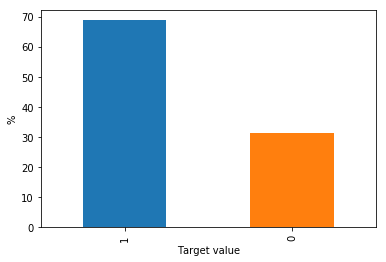

In [10]:
pl = df['class'].value_counts(normalize=True).mul(100).plot(kind='bar')
ay = pl.set_ylabel("%")
ax = pl.set_xlabel("Target value")

In [11]:
def wordcloud(dataframe ):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color="white",stopwords=stopwords).generate(" ".join([i for i in dataframe.str.upper()]))
    plt.imshow(wordcloud)
 


Not a "good" response:

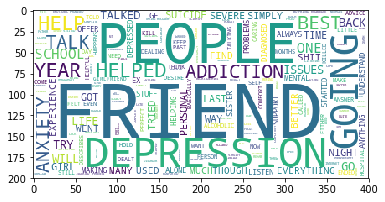

In [12]:
df0 = df[df['class'] == 0]
wordcloud(df0['response_text'])

"good" response:

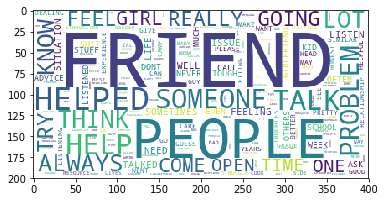

In [13]:
df1 = df[df['class'] == 1]
wordcloud(df1['response_text'])

We can see that the words: depression, help, addiction are significant in the not "good" responses. 

# Word2Vec using glove

In [14]:
# Class for storing glove vocabulary + hash tables for indices and words.
class Vocab:
    def __init__(self, embeddings_file):
        self.vec = []
        self.word_count = 0
        self.ind2word = {}
        self.word2ind = {}
        for line in open(embeddings_file,encoding="utf8"):
            values = line.split(" ")
            v = []
            for i in range (1, len(values)):
                v.append(float(values[i]))
            self.vec.append(v)
            self.ind2word[self.word_count] = values[0]
            self.word2ind[values[0]] = self.word_count
            self.word_count += 1

In [15]:
lang = Vocab('glove.6B.300d.txt')

In [16]:
print(lang.word2ind['sunrise'])

14714


In [17]:
print(len(lang.vec[lang.word2ind['sunrise']]))

300


# Preparing the data for training and test

In [18]:
nlp = en_core_web_sm.load()

In [19]:
#This function receives raw texr as input, turn it into spacy tokens and returns a tensor with the indices of the words in lang
def text2tensor(text, vocab):
    proc_sentence = nlp(text.lower())
    indexes = []
    for t in proc_sentence:
        if t.text in vocab.word2ind:
            indexes.append(vocab.word2ind[t.text])
    input_tensor = torch.LongTensor(indexes)
    return input_tensor

In [20]:
s = "It is a beautiful day."

In [21]:
text2tensor(s,lang)

tensor([  20,   14,    7, 3366,  122,    2])

In [22]:
#Every sentece  is processed
proc_data = []
labels = []

In [23]:
def append_data(sentence):
    proc_data.append(text2tensor(sentence,lang))
def append_label(label):
    labels.append(label)

In [24]:
temp = df['response_text'].apply(append_data)
temp = df['class'].apply(append_label)

In [25]:
data_idx = []
for i in range(0,len(labels)):
    data_idx.append(i)

In [26]:
# ChatbotDataset class inherites from pytorch Datset. 
#The data is stored as tensors. 
#I set x_data to be the indices of the proc_data

class ChatbotDataset(Dataset):
    def __init__(self , data_idx,labels):
        
        self.len = len(data_idx)
        self.x_data = torch.from_numpy(np.asarray(data_idx))
        self.y_data = torch.from_numpy(np.asarray(labels))
    
    def __getitem__(self,index):
        return self.x_data[index] , self.y_data[index]
    
    def __len__(self):
        return self.len
    
    def getratio(self):
        return (self.y_data[self.y_data == 1].size()[0] / self.y_data.size()[0])

In [27]:
ChatDataset = ChatbotDataset(data_idx,labels)

In [28]:
# I split the data to train and test data
train_size = int(0.8 * len(ChatDataset))
test_size = len(ChatDataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(ChatDataset, [train_size, test_size])

In [29]:
# I use DataLoader from PyTorch in order to make the dataset Iterative 
train_loader = DataLoader(dataset = train_dataset,
                         batch_size = 1,
                         shuffle = True,
                         num_workers = 0)

In [30]:
# I use DataLoader from PyTorch in order to make the dataset Iterative 
test_loader = DataLoader(dataset = test_dataset,
                         batch_size = 1,
                         shuffle = True,
                         num_workers = 0)

Size: 64
Precentage of 'good' answers: 0.6875
Precentage of 'bad' answers: 0.3125


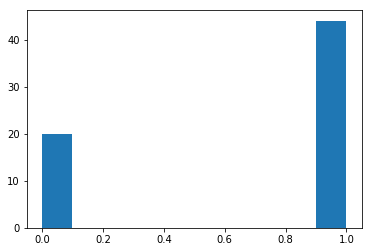

In [31]:
# I check if the train data and test data are divided in the same way. 
train_labels = []
for i, data in enumerate(train_loader, 0):
    # get the inputs
    inputs , labels = data
    train_labels.append(labels.item())
print ("Size:", len(train_labels))
print ("Precentage of 'good' answers:", train_labels.count(1) /len(train_labels) )
print ("Precentage of 'bad' answers:", train_labels.count(0) /len(train_labels) )
temp = plt.hist(train_labels)


Size: 16
Percentage of 'good' answers: 0.6875
Percentage of 'bad' answers: 0.3125


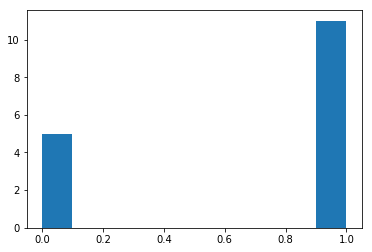

In [32]:
# I check if the train data and test data are divided in the same way. 
test_labels = []
for i, data in enumerate(test_loader, 0):
    # get the inputs
    inputs , labels = data
    test_labels.append(labels.item())
print ("Size:", len(test_labels))
print ("Percentage of 'good' answers:", test_labels.count(1) /len(test_labels) )
print ("Percentage of 'bad' answers:", test_labels.count(0) /len(test_labels) )
temp = plt.hist(test_labels)

# Evaluation parameters

TP: predicted to refer to response, and there is a need to refer it. 

TN: predicted not to refer the response, and there is no need to refer it.

Accuracy: the score rate. 

Precision: responses that should not be referred, are referred. Indicates low risk estimator. 

Recall: responses that should be referred are not referred. This an unwanted result. There is a risk to miss people who needs help. 

# NN model

The model architecture is: 

* Word2Vec using glove is the embedding layer (the weights are the vectors). Every vector is in size 300. 
* LSTM 3 layer. Hidden size is 256, bidirectional. 
* FC layer - [512X50]. 512 is the size of the last hidden layers * num_of_directions.
* Output layer - [50X1]. 

I use BCEWithLogitsLoss() loss function - therefore I dont need to add sigmoid after the output layer (it is include in the loss function). 

I use SGD optimizer with learning rate = 0.001 and momentum = 0.9


In [33]:
class Chatbot(nn.Module):
    
    def __init__(self, vocab, hidden_size, output_size, n_layers, num_directions):
        
        super(Chatbot, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.num_directions = num_directions   
        self.embedding = nn.Embedding(vocab.word_count, len(vocab.vec[0]))
        self.embedding.weight = nn.Parameter(torch.FloatTensor(vocab.vec))
        
        if (num_directions == 2):
            self.bidirectional = True
        else:
            self.bidirectional = False
            
        self.lstm = nn.LSTM(len(vocab.vec[0]), hidden_size, n_layers, bidirectional=self.bidirectional)
        self.l1 = nn.Linear(hidden_size*self.num_directions, 50) 
        self.out = nn.Linear(50, self.output_size) 
    
    def forward(self, input_text):
        
        input_text = proc_data[input_text]
        seq_len = len(input_text)
        embedded_words = self.embedding(input_text).view(seq_len, 1, -1)
        initial_hidden = self.init_hidden()
        rnn_outputs, hidden = self.lstm(embedded_words, initial_hidden)
        output = rnn_outputs[-1,0,:] 
        output = self.l1(output)
        output = self.out(output)
        
        return output
    
    
    def init_hidden(self):
        return (torch.zeros(self.n_layers*self.num_directions, 1, self.hidden_size),
                    torch.zeros(self.n_layers*self.num_directions, 1, self.hidden_size)) # hidden and cell states
    
    #This function is for debug purpose.     
    def get_hidden(self, input_text):
        input_text = proc_data[input_text]
        seq_len = len(input_text)
        embedded_words = self.embedding(input_text).view(seq_len, 1, -1)
        initial_hidden = self.init_hidden()
        rnn_outputs, hidden = self.lstm(embedded_words, initial_hidden)
        return rnn_outputs, hidden

In [34]:
# A function for calculating test loss.
def test_loss_calculation(network, test_data, criterion ,optimizer):
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_data, 0):
            inputs, labels = data
            # forward only
            outputs = network(inputs)
            loss_test = criterion(outputs.double(), labels.double())
            # print statistics
            running_loss += loss_test.item()
        return (running_loss / i)

In [35]:
# A function for calculating eval results.
def return_evals_and_lables(network, test_data, criterion ,optimizer ,thr = 0.5):
    eval_list = []
    labels_list = []
    sig = nn.Sigmoid()
    with torch.no_grad():
        for i, data in enumerate(test_data, 0):
            inputs, labels = data
            # forward only
            outputs = network(inputs)
            if outputs.item() > thr:
                eval_list.append(1)
            else:
                eval_list.append(0)
            labels_list.append(labels.item())
    return eval_list , labels_list

In [36]:
from sklearn.metrics import confusion_matrix

# A function for printing and caluate evaluation results.
def print_model_results(y,y_pred):
    cm = confusion_matrix(y, y_pred)
    tp = cm[0,0]
    tn = cm[1,1]
    fn = cm[0,1]
    fp = cm[1,0]
    acc = (tp + tn) / (tp + tn + fn + fp)
    print ("Accuracy:", acc )
    if ((tp + fp) != 0):
        prec = tp / (tp + fp)
        print ("Precision:", prec )
    else:
        print ("Precision:", '0' )
    if ((tp + fn) != 0):
        recall = tp / (tp + fn)
        print ("Recall:", recall )
    else:
        print ("Recall:", '0' )

In [37]:
#Train function. It prints the train loss and test loss during the training. 
def train(network ,train_data,test_data,input_criterion,input_optimizer , num_epochs=1 , print_running_loss = 0):
    epoch_list = []
    training_loss_list = []
    test_loss_list = []
    
    for epoch in range(num_epochs):  
        running_loss = 0.0
        training_loss = 0.0
        for i, data in enumerate(train_data, 0):
            # get the inputs
            inputs , labels = data
            # zero the parameter gradients
            input_optimizer.zero_grad()
            # forward + backward + optimize
            outputs = network(inputs)
            loss = input_criterion(outputs.double(), labels.double())
            loss.backward()
            input_optimizer.step()

            training_loss += loss.item()
            # print statistics
            if (print_running_loss == 1):
                running_loss += loss.item()
                if i % 10 == 0:    
                    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
                    running_loss = 0.0        
        epoch_list.append(epoch + 1)
        training_loss_list.append(training_loss/i)
        test_loss = test_loss_calculation(network, test_data, input_criterion ,input_optimizer)
        test_loss_list.append(test_loss)
        print('Epoch %d ===> train loss: %.3f, test loss: %.3f ' %(epoch + 1,training_loss / i, test_loss))
        
    return epoch_list, training_loss_list , test_loss_list
        

In [38]:
#Model paramets as explained above and instanstation 
n_layers = 3
hidden_size = 256 
output_size = 1
num_directions = 2

model = Chatbot(lang, hidden_size, output_size, n_layers , num_directions)

In [39]:
model

Chatbot(
  (embedding): Embedding(400000, 300)
  (lstm): LSTM(300, 256, num_layers=3, bidirectional=True)
  (l1): Linear(in_features=512, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=1, bias=True)
)

In [40]:
criterion = nn.BCEWithLogitsLoss()

In [41]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Training

In [42]:

epoch_l, training_loss_l , test_loss_l = train(model ,train_loader,test_loader, criterion , optimizer , num_epochs=160)


Epoch 1 ===> train loss: 0.697, test loss: 0.718 
Epoch 2 ===> train loss: 0.673, test loss: 0.697 
Epoch 3 ===> train loss: 0.657, test loss: 0.683 
Epoch 4 ===> train loss: 0.648, test loss: 0.676 
Epoch 5 ===> train loss: 0.642, test loss: 0.670 
Epoch 6 ===> train loss: 0.639, test loss: 0.667 
Epoch 7 ===> train loss: 0.637, test loss: 0.666 
Epoch 8 ===> train loss: 0.635, test loss: 0.665 
Epoch 9 ===> train loss: 0.635, test loss: 0.664 
Epoch 10 ===> train loss: 0.635, test loss: 0.664 
Epoch 11 ===> train loss: 0.633, test loss: 0.664 
Epoch 12 ===> train loss: 0.633, test loss: 0.663 
Epoch 13 ===> train loss: 0.632, test loss: 0.663 
Epoch 14 ===> train loss: 0.632, test loss: 0.663 
Epoch 15 ===> train loss: 0.632, test loss: 0.663 
Epoch 16 ===> train loss: 0.634, test loss: 0.663 
Epoch 17 ===> train loss: 0.632, test loss: 0.663 
Epoch 18 ===> train loss: 0.632, test loss: 0.663 
Epoch 19 ===> train loss: 0.634, test loss: 0.663 
Epoch 20 ===> train loss: 0.632, test lo

Epoch 160 ===> train loss: 0.003, test loss: 1.928 


## Number of epochs optimization

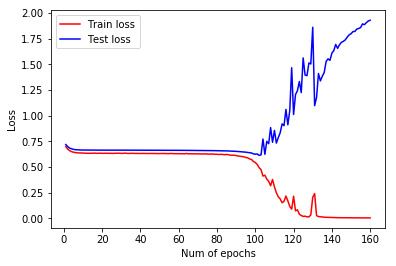

In [43]:
training_plt, = plt.plot(epoch_l, training_loss_l, 'r') # plotting t, a separately 
test_plt, = plt.plot(epoch_l,test_loss_l, 'b') # plotting t, b separately 
plt.legend([training_plt, test_plt],["Train loss","Test loss"])
plt.xlabel("Num of epochs")
plt.ylabel("Loss")
plt.show()

We can see that after ~100 epochs, test loss is increasing. This is the point when the model starts to overfit. In order optimize the model, i retrain it with number_of epochs = 80.

## Retrain

In [44]:
#delete the model and other objects in order to release memory
del model
del criterion
del optimizer

In [48]:
n_layers = 3
hidden_size = 256 
output_size = 1
num_directions = 2

opt_model = Chatbot(lang, hidden_size, output_size, n_layers , num_directions)
opt_criterion = nn.BCEWithLogitsLoss()
opt_optimizer = torch.optim.SGD(opt_model.parameters(), lr=0.001, momentum=0.9)

In [49]:
opt_epoch_l, opt_training_loss_l , opt_test_loss_l = train(opt_model ,train_loader,test_loader, opt_criterion , opt_optimizer , num_epochs=80)

Epoch 1 ===> train loss: 0.692, test loss: 0.715 
Epoch 2 ===> train loss: 0.672, test loss: 0.695 
Epoch 3 ===> train loss: 0.655, test loss: 0.681 
Epoch 4 ===> train loss: 0.647, test loss: 0.676 
Epoch 5 ===> train loss: 0.641, test loss: 0.671 
Epoch 6 ===> train loss: 0.637, test loss: 0.668 
Epoch 7 ===> train loss: 0.635, test loss: 0.666 
Epoch 8 ===> train loss: 0.635, test loss: 0.666 
Epoch 9 ===> train loss: 0.634, test loss: 0.664 
Epoch 10 ===> train loss: 0.635, test loss: 0.664 
Epoch 11 ===> train loss: 0.633, test loss: 0.664 
Epoch 12 ===> train loss: 0.633, test loss: 0.663 
Epoch 13 ===> train loss: 0.632, test loss: 0.663 
Epoch 14 ===> train loss: 0.632, test loss: 0.663 
Epoch 15 ===> train loss: 0.632, test loss: 0.663 
Epoch 16 ===> train loss: 0.633, test loss: 0.663 
Epoch 17 ===> train loss: 0.632, test loss: 0.663 
Epoch 18 ===> train loss: 0.632, test loss: 0.663 
Epoch 19 ===> train loss: 0.632, test loss: 0.663 
Epoch 20 ===> train loss: 0.632, test lo

# Results

I set the threshold value to be 0.85, so that Recall value is maximized (according to our goal). 

In [99]:
ev, lables = return_evals_and_lables(opt_model, test_loader, opt_criterion ,opt_optimizer , thr=0.85)

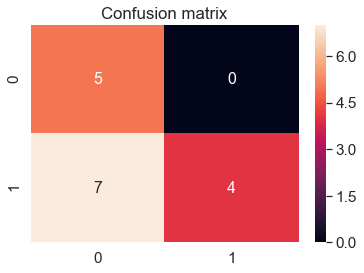

In [100]:
cm = confusion_matrix(lables,ev)
df_cm = pd.DataFrame(cm, range(2),range(2))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
plt.title("Confusion matrix")
plt.show()

In [102]:
print_model_results(lables,ev)

Accuracy: 0.5625
Precision: 0.4166666666666667
Recall: 1.0


# Conclusions

* The model can be used as a decision maker for the chatbot with threshold value = 0.85.
* Recall value is maximized (FN = 0, every response that should be referred is referred). 
* Precision results are not optimal (some of the responses that should not be referred are referred).





     


# Future work

1. More ways to optimize the model should be examined: dropouts, hyper parameters optimization, different architectures.
2. Get more data / create augmented data. 80 responses are not enough.